In [1]:
import json
import numpy as np
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from matplotlib.colors import ListedColormap
import random

In [2]:
# matplotlib 한글 폰트 깨쥠 문제 해결
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fontprop = fm.FontProperties(fname=font_path)

#### 파일 업로드

In [3]:
# 경로 설정

data_path = '/workspace/#Ub370#Uc774#Ud130/Data'

train_img_path = '/workspace/#Ub370#Uc774#Ud130/Data/img/train/'
val_img_path = '/workspace/#Ub370#Uc774#Ud130/Data/img/val/'

train_json_path = '/workspace/#Ub370#Uc774#Ud130/Data/label/train/'
val_json_path = '/workspace/#Ub370#Uc774#Ud130/Data/label/val/'


train_segment_path = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/train/'
val_segment_path = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/'

In [4]:
# 라벨 정보 json 파일
# json_anger, json_happy, json_panic, json_sadness

with open (train_json_path + "train_anger.json", "r", encoding='euc-kr') as f:
    json_anger = json.load(f)

with open (train_json_path + "train_happy.json", "r", encoding='euc-kr') as f:
    json_happy = json.load(f)

with open (train_json_path + "train_panic.json", "r", encoding='euc-kr') as f:
    json_panic = json.load(f)

with open (train_json_path + "train_sadness.json", "r", encoding='euc-kr') as f:
    json_sadness = json.load(f)

In [5]:
# Segmentation 정보 npz 파일
# npz_anger, npz_happy, npz_panic, npz_sadness

npz_anger = np.load(train_segment_path + 'train_anger.npz')
npz_happy = np.load(train_segment_path + 'train_happy.npz')
npz_panic = np.load(train_segment_path + 'train_panic.npz')
npz_sadness = np.load(train_segment_path + 'train_sadness.npz')

### JSON 파일

In [6]:
json_panic[0]

{'filename': 'twdva8d723865fa1005873a6967797c75f3dd83197f13f7daa3e3926947071al6.jpg',
 'gender': '여',
 'age': 20,
 'isProf': '일반인',
 'faceExp_uploader': '당황',
 'bg_uploader': '상업시설/점포/시장',
 'annot_A': {'boxes': {'maxX': 2289.351,
   'maxY': 1162.7544,
   'minX': 1471.1471,
   'minY': 213.07580000000002},
  'faceExp': '중립',
  'bg': '상업시설/점포/시장'},
 'annot_B': {'boxes': {'maxX': 2280.8636809336676,
   'maxY': 1144.8658917460868,
   'minX': 1523.7319800419439,
   'minY': 142.7691863026925},
  'faceExp': '당황',
  'bg': '상업시설/점포/시장'},
 'annot_C': {'boxes': {'maxX': 2289.351,
   'maxY': 1162.7544000000003,
   'minX': 1471.1471,
   'minY': 213.07580000000002},
  'faceExp': '당황',
  'bg': '상업시설/점포/시장'}}

In [7]:
# Json 파일 -> DataFrame 변환
# df_train_anger, df_train_happy, df_train_panic, df_train_sadness

# 데이터 변환 함수 정의
def process_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # annot_A, annot_B, annot_C 데이터 추가
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            row = {
                **base_info,
                'annot': annot_key,
                'faceExp': annot.get('faceExp'),
                'bg': annot.get('bg'),
                'minX': annot.get('boxes', {}).get('minX'),
                'minY': annot.get('boxes', {}).get('minY'),
                'maxX': annot.get('boxes', {}).get('maxX'),
                'maxY': annot.get('boxes', {}).get('maxY'),
            }
            processed_data.append(row)
    return pd.DataFrame(processed_data)

# 데이터프레임 생성
df_train_anger = process_data(json_anger)
df_train_happy = process_data(json_happy)
df_train_panic = process_data(json_panic)
df_train_sadness = process_data(json_sadness)


##### 이미지와 json 파일 내 filename이 일치하는 지 확인

In [8]:
panic_img_path = train_img_path + 'panic'

IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count

image_count = count_images_in_folder(panic_img_path)
print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"json 파일 길이 : {len(json_panic)}")

폴더 내 이미지 파일 개수: 1500
json 파일 길이 : 1500


In [ ]:
# 폴더 내 이미지 파일 이름 수집
def get_image_files_in_folder(folder_path):
    image_files = set()
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_files.add(file)
    return image_files

# JSON 파일 내 이미지 파일 이름 수집
def get_image_files_in_json(json_file):
    json_filenames = {entry["filename"] for entry in json_file}
    return json_filenames

# 비교 수행
image_files_in_folder = get_image_files_in_folder(panic_img_path)
image_files_in_json = get_image_files_in_json(json_panic)

# 누락된 파일 찾기
missing_in_json = image_files_in_folder - image_files_in_json
missing_in_folder = image_files_in_json - image_files_in_folder

# 결과 출력
print(f"JSON 파일에 없는 폴더 내 이미지 파일: {missing_in_json}")
print(f"폴더에 없는 JSON 파일의 이미지 파일: {missing_in_folder}")

JSON 파일에 없는 폴더 내 이미지 파일: set()
폴더에 없는 JSON 파일의 이미지 파일: set()


#### Train Panic

In [10]:
df_train_panic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          4500 non-null   object 
 1   gender            4500 non-null   object 
 2   age               4500 non-null   int64  
 3   isProf            4500 non-null   object 
 4   faceExp_uploader  4500 non-null   object 
 5   bg_uploader       4500 non-null   object 
 6   annot             4500 non-null   object 
 7   faceExp           4500 non-null   object 
 8   bg                4500 non-null   object 
 9   minX              4500 non-null   float64
 10  minY              4500 non-null   float64
 11  maxX              4500 non-null   float64
 12  maxY              4500 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 457.2+ KB


In [11]:
df_train_panic

filename gender  age isProf  \
0     twdva8d723865fa1005873a6967797c75f3dd83197f13f...      여   20    일반인   
1     twdva8d723865fa1005873a6967797c75f3dd83197f13f...      여   20    일반인   
2     twdva8d723865fa1005873a6967797c75f3dd83197f13f...      여   20    일반인   
3     tfcq8e7c42da5f56ce61f3ef372a3fe8339f4670407966...      남   30    전문인   
4     tfcq8e7c42da5f56ce61f3ef372a3fe8339f4670407966...      남   30    전문인   
...                                                 ...    ...  ...    ...   
4495  ydui290057bcb258b1bbaebdbbb28811eac028412f29cb...      여   20    전문인   
4496  ydui290057bcb258b1bbaebdbbb28811eac028412f29cb...      여   20    전문인   
4497  pj49da3cbf640f6c0b5f48cffac80f7964aaae4f0f01a0...      남   20    전문인   
4498  pj49da3cbf640f6c0b5f48cffac80f7964aaae4f0f01a0...      남   20    전문인   
4499  pj49da3cbf640f6c0b5f48cffac80f7964aaae4f0f01a0...      남   20    전문인   

     faceExp_uploader bg_uploader    annot faceExp          bg         minX  \
0                  당황  상업시설/점포/시장  annot_A      중립  상업시설/점포/시장  1471.147100   
1                  당황  상업시설/점포/시장  annot_B      당황  상업시설/점포/시장  1523.731980   
2                  당황  상업시설/점포/시장  annot_C      당황  상업시설/점포/시장  1471.147100   
3                  당황       도심 환경  annot_A      당황     실외 자연환경  1147.099757   
4                  당황       도심 환경  annot_B      중립       도심 환경  1156.344622   
...               ...         ...      ...     ...         ...          ...   
4495               당황       도심 환경  annot_B      중립       도심 환경   972.390825   
4496               당황       도심 환경  annot_C      중립       도심 환경   977.457255   
4497               당황     실외 자연환경  annot_A      당황     실외 자연환경   959.306640   
4498               당황     실외 자연환경  annot_B      상처     실외 자연환경  1005.629993   
4499               당황     실외 자연환경  annot_C      당황     실외 자연환경   959.306640   

            minY         maxX         maxY  
0     213.075800  2289.351000  1162.754400  
1     142.769186  2280.863681  1144.865892  
2     213.075800  2289.351000  1162.754400  
3     219.311950  2129.559344  1594.946500  
4     364.474895  2101.320494  1598.860145  
...          ...          ...          ...  
4495  430.938189  1697.489788  1352.091939  
4496  415.152194  1688.098158  1343.115632  
4497  703.536100  1742.572800  1805.191000  
4498  745.234962  1728.925979  1772.828291  
4499  703.536100  1742.572800  1805.191000  

[4500 rows x 13 columns]

##### 표정 데이터 확인
- faceExp_uploader (image) 와 faceExp (annot) 차이 확인
- 표정 정보가 다른 이미지들 어떻게 처리할지

In [12]:
df_train_panic['faceExp_uploader'].value_counts()

faceExp_uploader
당황    4500
Name: count, dtype: int64

In [13]:
df_train_panic['faceExp'].value_counts()

faceExp
당황    3148
불안     416
중립     259
상처     215
기쁨     197
분노     166
슬픔      99
Name: count, dtype: int64

In [14]:
# faceExp가 당황이 아닌 데이터 추출
def process_non_panic_data(data):
    processed_data = []
    for item in data:
        base_info = {
            'filename': item.get('filename'),
            'gender': item.get('gender'),
            'age': item.get('age'),
            'isProf': item.get('isProf'),
            'faceExp_uploader': item.get('faceExp_uploader'),
            'bg_uploader': item.get('bg_uploader'),
        }

        # Process each annotation and filter for non-panic faceExp
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            annot = item.get(annot_key, {})
            face_exp = annot.get('faceExp')
            if face_exp != "당황":  # Only include non-panic faceExp
                row = {
                    **base_info,
                    'annot': annot_key,
                    'faceExp': face_exp,
                    'bg': annot.get('bg'),
                    'minX': annot.get('boxes', {}).get('minX'),
                    'minY': annot.get('boxes', {}).get('minY'),
                    'maxX': annot.get('boxes', {}).get('maxX'),
                    'maxY': annot.get('boxes', {}).get('maxY'),
                }
                processed_data.append(row)
    return pd.DataFrame(processed_data)

df_train_not_panic = process_non_panic_data(json_panic)

In [15]:
df_train_not_panic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          1352 non-null   object 
 1   gender            1352 non-null   object 
 2   age               1352 non-null   int64  
 3   isProf            1352 non-null   object 
 4   faceExp_uploader  1352 non-null   object 
 5   bg_uploader       1352 non-null   object 
 6   annot             1352 non-null   object 
 7   faceExp           1352 non-null   object 
 8   bg                1352 non-null   object 
 9   minX              1352 non-null   float64
 10  minY              1352 non-null   float64
 11  maxX              1352 non-null   float64
 12  maxY              1352 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 137.4+ KB


In [16]:
df_train_not_panic

filename gender  age isProf  \
0     twdva8d723865fa1005873a6967797c75f3dd83197f13f...      여   20    일반인   
1     tfcq8e7c42da5f56ce61f3ef372a3fe8339f4670407966...      남   30    전문인   
2     tfcq8e7c42da5f56ce61f3ef372a3fe8339f4670407966...      남   30    전문인   
3     1x46281aba4fc588baac2be45c9ef57caaa788a14aa2bc...      여   20    전문인   
4     1x46281aba4fc588baac2be45c9ef57caaa788a14aa2bc...      여   20    전문인   
...                                                 ...    ...  ...    ...   
1347  61rr9c4409c1044f04491f9f48f1f6f3b8f30cd04bdaaa...      여   30    일반인   
1348  ydui290057bcb258b1bbaebdbbb28811eac028412f29cb...      여   20    전문인   
1349  ydui290057bcb258b1bbaebdbbb28811eac028412f29cb...      여   20    전문인   
1350  ydui290057bcb258b1bbaebdbbb28811eac028412f29cb...      여   20    전문인   
1351  pj49da3cbf640f6c0b5f48cffac80f7964aaae4f0f01a0...      남   20    전문인   

     faceExp_uploader bg_uploader    annot faceExp          bg         minX  \
0                  당황  상업시설/점포/시장  annot_A      중립  상업시설/점포/시장  1471.147100   
1                  당황       도심 환경  annot_B      중립       도심 환경  1156.344622   
2                  당황       도심 환경  annot_C      중립       도심 환경  1106.302407   
3                  당황  상업시설/점포/시장  annot_B      불안  상업시설/점포/시장  1122.588426   
4                  당황  상업시설/점포/시장  annot_C      불안  상업시설/점포/시장  1120.573320   
...               ...         ...      ...     ...         ...          ...   
1347               당황   숙박 및 거주공간  annot_A      불안   숙박 및 거주공간  2912.417033   
1348               당황       도심 환경  annot_A      분노       도심 환경   984.167700   
1349               당황       도심 환경  annot_B      중립       도심 환경   972.390825   
1350               당황       도심 환경  annot_C      중립       도심 환경   977.457255   
1351               당황     실외 자연환경  annot_B      상처     실외 자연환경  1005.629993   

            minY         maxX         maxY  
0     213.075800  2289.351000  1162.754400  
1     364.474895  2101.320494  1598.860145  
2     251.019522  2132.298807  1626.654072  
3     654.313748  1793.116429  1536.142498  
4     649.473483  1793.209047  1545.485191  
...          ...          ...          ...  
1347  253.393359  4078.617083  2052.183953  
1348  435.714750  1664.230000  1356.868500  
1349  430.938189  1697.489788  1352.091939  
1350  415.152194  1688.098158  1343.115632  
1351  745.234962  1728.925979  1772.828291  

[1352 rows x 13 columns]

In [17]:
df_train_not_panic['faceExp'].value_counts()

faceExp
불안    416
중립    259
상처    215
기쁨    197
분노    166
슬픔     99
Name: count, dtype: int64

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


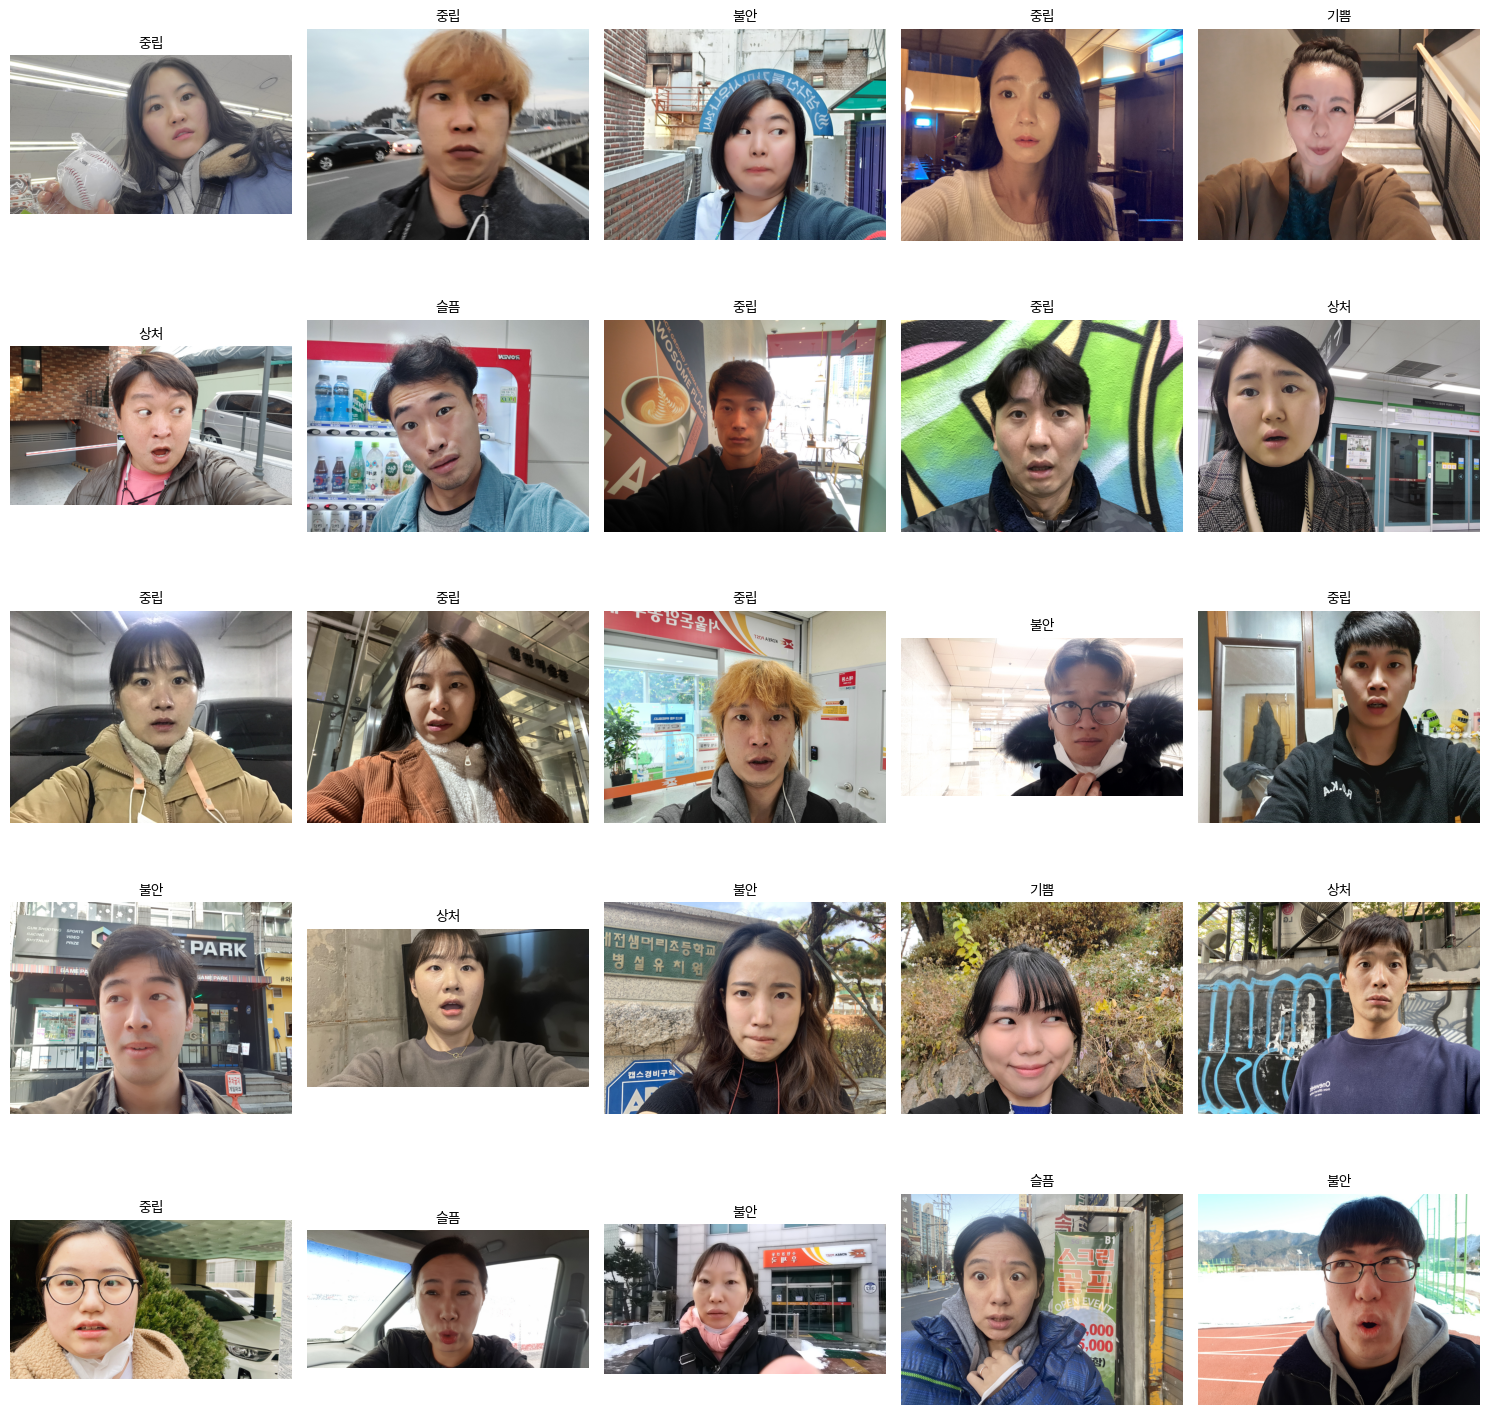

In [18]:
# 감정 정보가 다른 이미지 시각화
unique_filenames = df_train_not_panic['filename'].unique()

plt.figure(figsize=(15, 15))

for i, filename in enumerate(unique_filenames):
    if i >= 25:  # Show only the first 25 images for this example
        break
    image_path = os.path.join(train_img_path, 'panic', filename)
    if os.path.exists(image_path):  # Ensure the file exists
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        faceExp = df_train_not_panic[df_train_not_panic['filename'] == filename]['faceExp'].iloc[0]
        plt.title(faceExp, fontproperties=fontprop)
        plt.axis('off')

plt.tight_layout()
plt.show()

##### 연령, 성별, 전문인 column 분포 확인

In [19]:
# 연령 분포 확인
df_train_panic['age'].value_counts()

age
20    2385
30    1416
40     519
50     135
10      45
Name: count, dtype: int64

In [20]:
# 성별 분포 확인
df_train_panic['gender'].value_counts()

gender
여    2352
남    2148
Name: count, dtype: int64

In [21]:
# 전문인 여부
df_train_panic['isProf'].value_counts()

isProf
일반인    2310
전문인    2190
Name: count, dtype: int64

##### 배경 정보 확인
- bg_uploader와 bg 차이 확인
- 배경 정보가 다른 이미지들 어떻게 처리할지

In [22]:
# 배경 정보
df_train_panic['bg_uploader'].value_counts(), df_train_panic['bg'].value_counts()

(bg_uploader
 숙박 및 거주공간            834
 상업시설/점포/시장           708
 도심 환경                579
 공공시설/종교/의료시설         534
 실외 자연환경              462
 교통/이동수단(엘리베이터 포함)    444
 오락/공연시설              246
 문화재 및 유적지            237
 행사/사무공간              234
 스포츠 관람 및 레저시설        222
 Name: count, dtype: int64,
 bg
 숙박 및 거주공간            852
 상업시설/점포/시장           766
 공공시설/종교/의료           673
 도심 환경                554
 실외 자연환경              473
 교통/이동수단(엘리베이터 포함)    376
 행사/사무공간              268
 오락/공연시설              242
 스포츠 관람 및 레저시설        159
 문화재 및 유적지            113
 공공시설/종교/의료시설          24
 Name: count, dtype: int64)

##### 박스 좌표 정보 확인
- 한 이미지 내 박스 좌표가 유사한지 시각화 및 좌표 수치 확인

In [24]:
panic_img_path

'/workspace/#Ub370#Uc774#Ud130/Data/img/train/panic'

Invalid SOS parameters for sequential JPEG


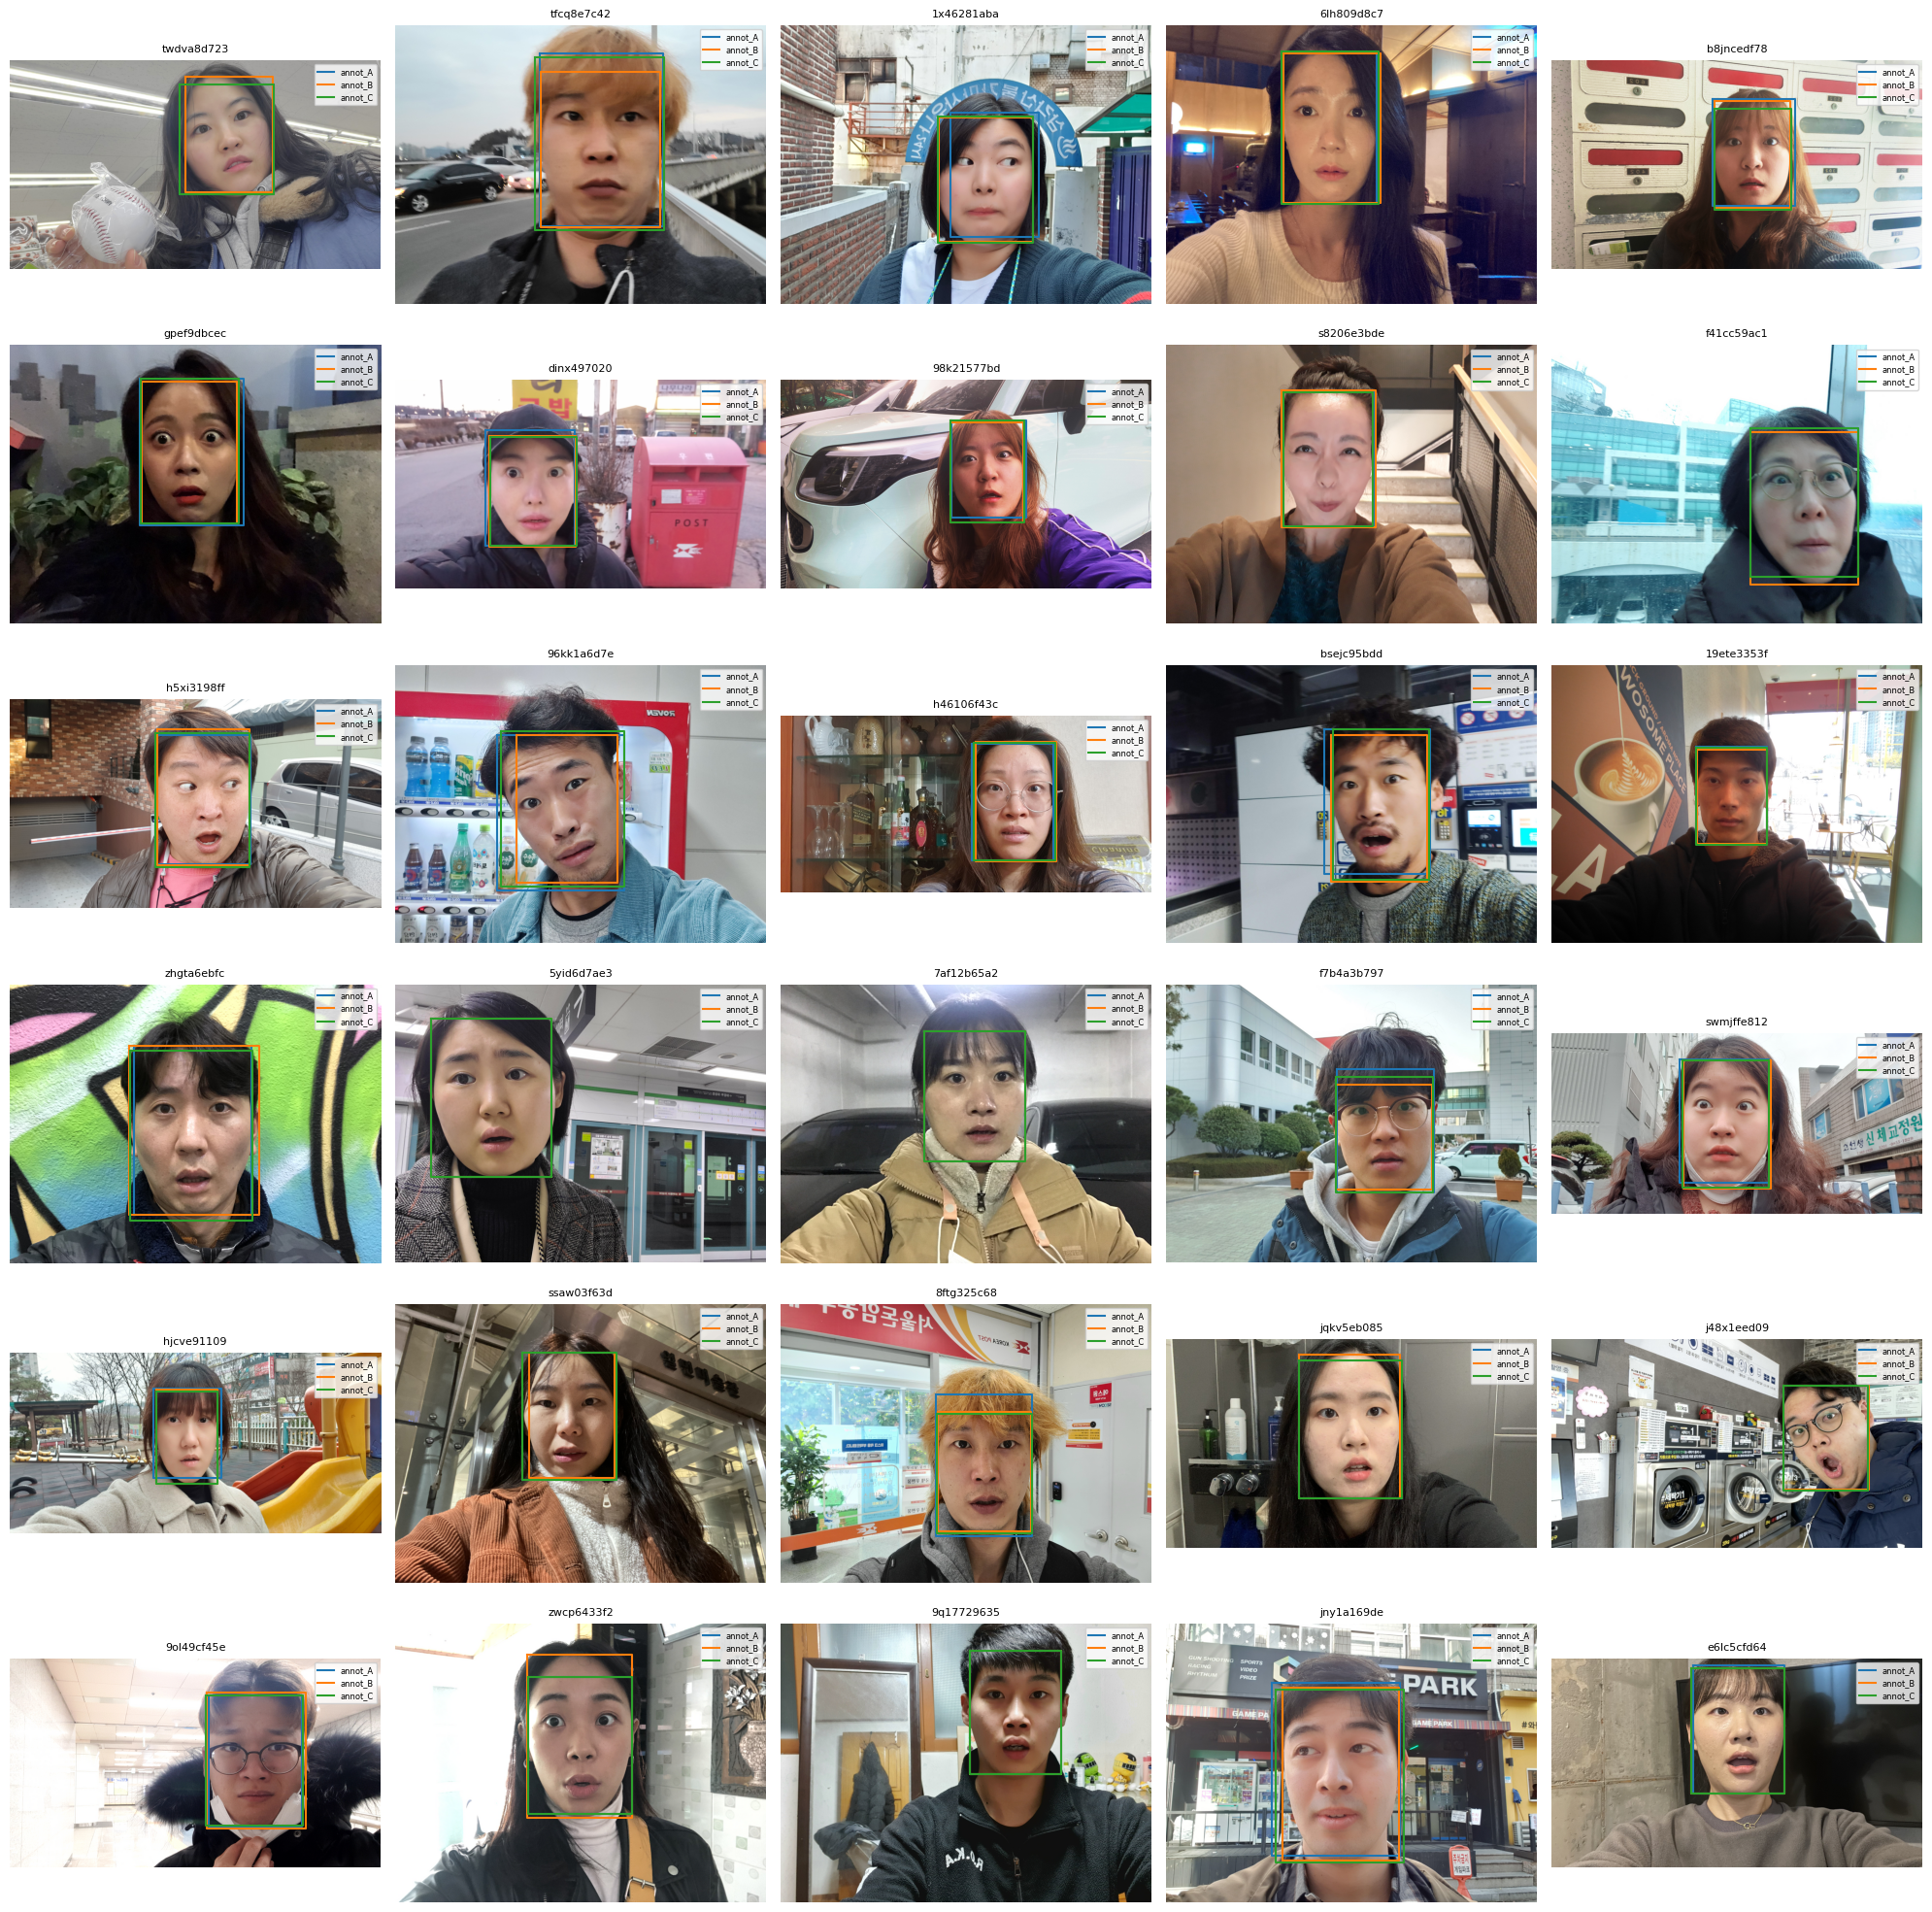

In [ ]:
# 이미지 & 박스 시각화

def visualize_boxes(data, image_dir):
    data = data[:30]  # 30개 이미지만 시각화
    fig, axes = plt.subplots(6, 5, figsize=(20, 20))
    axes = axes.ravel()

    for idx, item in enumerate(data):
        filename = item['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            continue

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image) 
        axes[idx].axis('off')

        # Plot boxes from annotations
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            if annot_key in item:
                box = item[annot_key]['boxes']
                x = [box['minX'], box['maxX'], box['maxX'], box['minX'], box['minX']]
                y = [box['minY'], box['minY'], box['maxY'], box['maxY'], box['minY']]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)
       
    # Hide unused subplots
    for i in range(len(data), 30):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_boxes(json_panic, panic_img_path)

In [26]:
# 박스 좌표 수치 확인

# 임의로 10개의 파일 이름 선택
sample_filenames = df_train_panic['filename'].drop_duplicates().sample(n=10)

# 선택된 파일 이름에 대한 그룹 생성
sample_groups = df_train_panic[df_train_panic['filename'].isin(sample_filenames)]

# 같은 파일 이름끼리 그룹화
grouped = sample_groups.groupby('filename')

# 그룹 내 좌표 출력
for filename, group in grouped:
    print(f"Filename: {filename}")
    
    # 그룹 내 각 annot의 좌표 정보 출력
    for idx, row in group.iterrows():
        annot = row['annot']
        min_x, min_y, max_x, max_y = row['minX'], row['minY'], row['maxX'], row['maxY']
        print(f"  Annot: {annot}")
        print(f"    MinX: {min_x}, MinY: {min_y}")
        print(f"    MaxX: {max_x}, MaxY: {max_y}")
    
    print("-" * 30)

Filename: 6w4d191a1004f3f598570868a94edfa73a5e55655fd47f16f1af04488a866ke3h.jpg
  Annot: annot_A
    MinX: 1351.6582848197595, MinY: 956.357169413386
    MaxX: 2147.7829234396017, MaxY: 2023.4165170096119
  Annot: annot_B
    MinX: 1357.5762934656814, MinY: 882.3774888423916
    MaxX: 2161.7900993010458, MaxY: 2007.6647888423913
  Annot: annot_C
    MinX: 1344.9241633323525, MinY: 814.0483515861026
    MaxX: 2162.9075644006125, MaxY: 2022.56015662185
------------------------------
Filename: 94g605c6b5b3bb8bb4ad192151d9a6ce4723706bdc0d3870b6c5170404b0dm7re.jpg
  Annot: annot_A
    MinX: 779.6152926578841, MinY: 200.62634543832937
    MaxX: 1475.095898338285, MaxY: 1296.2005268392352
  Annot: annot_B
    MinX: 779.8875342838588, MinY: 202.59414036833078
    MaxX: 1481.8706630513525, MaxY: 1295.2225227765932
  Annot: annot_C
    MinX: 782.7122500628772, MinY: 189.29577464788733
    MaxX: 1481.9476625377263, MaxY: 1305.7545271629779
------------------------------
Filename: bbo074e48302c7d2